In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Installing required libraries
!pip -q install rdkit-pypi
!pip -q install Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 49.3 MB/s eta 0:00:00


In [3]:
# Importing necessary libraries
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [4]:
# Disabling RDKit logger
RDLogger.DisableLog("rdApp.*")

In [5]:
# Path to the CSV file containing SMILES data
csv_path = "./gdrive/My Drive/graph-generation/qm9.csv"

In [6]:
# Reading SMILES data from the CSV file
data = []
with open(csv_path, "r") as f:
    for line in f.readlines()[1:]:
        data.append(line.split(",")[1])

In [7]:
# Selecting a SMILES string from the data
smiles = data[1000]
print("SMILES:", smiles)

SMILES: Cn1cncc1O


Num heavy atoms: 7


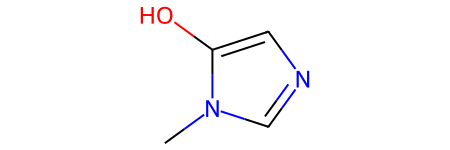

In [8]:
# Converting the SMILES string to an RDKit molecule object
molecule = Chem.MolFromSmiles(smiles)
print("Num heavy atoms:", molecule.GetNumHeavyAtoms())
molecule

In [9]:
# Mapping atom symbols to integers and vice versa
atom_mapping = {
    "C": 0,
    0: "C",
    "N": 1,
    1: "N",
    "O": 2,
    2: "O",
    "F": 3,
    3: "F",
}

In [10]:
# Mapping bond types to integers and vice versa
bond_mapping = {
    "SINGLE": 0,
    0: Chem.BondType.SINGLE,
    "DOUBLE": 1,
    1: Chem.BondType.DOUBLE,
    "TRIPLE": 2,
    2: Chem.BondType.TRIPLE,
    "AROMATIC": 3,
    3: Chem.BondType.AROMATIC,
}

In [11]:
# Constants for graph generation
NUM_ATOMS = 9
ATOM_DIM = 4 + 1
BOND_DIM = 4 + 1
LATENT_DIM = 64

In [12]:
# Function to convert a SMILES string to a graph representation
def smiles_to_graph(smiles):
    # Converting SMILES to an RDKit molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initializing adjacency and features matrices
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # Processing atoms and bonds in the molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Handling disconnected atoms and empty features
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features


In [13]:
# Function to convert a graph representation to an RDKit molecule object
def graph_to_molecule(graph):
    adjacency, features = graph
    molecule = Chem.RWMol()

    # Selecting atoms and bonds for the final molecule
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Adding atoms to the molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Adding bonds to the molecule
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Checking and sanitizing the molecule
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule


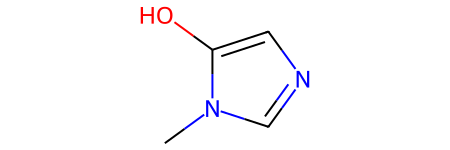

In [14]:
# Generating graph representation for a given SMILES string
graph_to_molecule(smiles_to_graph(smiles))


In [15]:
# Converting a subset of SMILES data to graph tensors
adjacency_tensor, feature_tensor = [], []
for smiles in data[::10]:
    adjacency, features = smiles_to_graph(smiles)
    adjacency_tensor.append(adjacency)
    feature_tensor.append(features)
adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)
print("adjacency_tensor.shape =", adjacency_tensor.shape)
print("feature_tensor.shape =", feature_tensor.shape)

adjacency_tensor.shape = (13389, 5, 9, 9)
feature_tensor.shape = (13389, 9, 5)


In [16]:
# Function to create the generator model
def GraphGenerator(dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape):
    z = keras.layers.Input(shape=(LATENT_DIM,))
    x = z
    for units in dense_units:
        x = keras.layers.Dense(units, activation="tanh")(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    x_adjacency = keras.layers.Dense(tf.math.reduce_prod(adjacency_shape))(x)
    x_adjacency = keras.layers.Reshape(adjacency_shape)(x_adjacency)
    x_adjacency = (x_adjacency + tf.transpose(x_adjacency, (0, 1, 3, 2))) / 2
    x_adjacency = keras.layers.Softmax(axis=1)(x_adjacency)
    x_features = keras.layers.Dense(tf.math.reduce_prod(feature_shape))(x)
    x_features = keras.layers.Reshape(feature_shape)(x_features)
    x_features = keras.layers.Softmax(axis=2)(x_features)
    return keras.Model(inputs=z, outputs=[x_adjacency, x_features], name="Generator")


In [17]:
# Creating the generator model
generator = GraphGenerator(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)
generator.summary()


Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          8320        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 256)          33024       ['dropout[0][0]']                
                                                                                          

In [18]:
# Class for relational graph convolutional layer
class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(self, units=128, activation="relu", use_bias=False, kernel_initializer="glorot_uniform",
                 bias_initializer="zeros", kernel_regularizer=None, bias_regularizer=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]
        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )
        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )
        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        x = tf.matmul(adjacency, features[:, None, :, :])
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        x_reduced = tf.reduce_sum(x, axis=1)
        return self.activation(x_reduced)


In [19]:
# Function to create the discriminator model
def GraphDiscriminator(gconv_units, dense_units, dropout_rate, adjacency_shape, feature_shape):
    adjacency = keras.layers.Input(shape=adjacency_shape)
    features = keras.layers.Input(shape=feature_shape)
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)([adjacency, features_transformed])
    x = keras.layers.GlobalAveragePooling1D()(features_transformed)
    for units in dense_units:
        x = keras.layers.Dense(units, activation="relu")(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    x_out = keras.layers.Dense(1, dtype="float32")(x)
    return keras.Model(inputs=[adjacency, features], outputs=x_out)


In [20]:
# Creating the discriminator model
discriminator = GraphDiscriminator(
    gconv_units=[128, 128, 128, 128],
    dense_units=[512, 512],
    dropout_rate=0.2,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5, 9, 9)]    0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 9, 5)]       0           []                               
                                                                                                  
 relational_graph_conv_layer (R  (None, 9, 128)      3200        ['input_2[0][0]',                
 elationalGraphConvLayer)                                         'input_3[0][0]']                
                                                                                                  
 relational_graph_conv_layer_1   (None, 9, 128)      81920       ['input_2[0][0]',            

In [21]:
# Class for the graph Wasserstein GAN
class GraphWGAN(keras.Model):
    def __init__(self, generator, discriminator, discriminator_steps=1, generator_steps=1, gp_weight=10, **kwargs):
        super().__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.discriminator_steps = discriminator_steps
        self.generator_steps = generator_steps
        self.gp_weight = gp_weight
        self.latent_dim = self.generator.input_shape[-1]

    def compile(self, optimizer_generator, optimizer_discriminator, **kwargs):
        super().compile(**kwargs)
        self.optimizer_generator = optimizer_generator
        self.optimizer_discriminator = optimizer_discriminator
        self.metric_generator = keras.metrics.Mean(name="loss_gen")
        self.metric_discriminator = keras.metrics.Mean(name="loss_dis")

    def train_step(self, inputs):
        if isinstance(inputs[0], tuple):
            inputs = inputs[0]
        graph_real = inputs
        self.batch_size = tf.shape(inputs[0])[0]

        for _ in range(self.discriminator_steps):
            z = tf.random.normal((self.batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                graph_generated = self.generator(z, training=True)
                loss = self._loss_discriminator(graph_real, graph_generated)
            grads = tape.gradient(loss, self.discriminator.trainable_weights)
            self.optimizer_discriminator.apply_gradients(zip(grads, self.discriminator.trainable_weights))
            self.metric_discriminator.update_state(loss)

        for _ in range(self.generator_steps):
            z = tf.random.normal((self.batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                graph_generated = self.generator(z, training=True)
                loss = self._loss_generator(graph_generated)
                grads = tape.gradient(loss, self.generator.trainable_weights)
                self.optimizer_generator.apply_gradients(zip(grads, self.generator.trainable_weights))
                self.metric_generator.update_state(loss)

        return {m.name: m.result() for m in self.metrics}

    def _loss_discriminator(self, graph_real, graph_generated):
        logits_real = self.discriminator(graph_real, training=True)
        logits_generated = self.discriminator(graph_generated, training=True)
        loss = tf.reduce_mean(logits_generated) - tf.reduce_mean(logits_real)
        loss_gp = self._gradient_penalty(graph_real, graph_generated)
        return loss + loss_gp * self.gp_weight

    def _loss_generator(self, graph_generated):
        logits_generated = self.discriminator(graph_generated, training=True)
        return -tf.reduce_mean(logits_generated)

    def _gradient_penalty(self, graph_real, graph_generated):
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated
        alpha = tf.random.uniform([self.batch_size])
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
        features_interp = (features_real * alpha) + (1 - alpha) * features_generated
        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            logits = self.discriminator([adjacency_interp, features_interp], training=True)
        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        grads_adjacency_penalty = (1 - tf.norm(grads[0], axis=1)) ** 2
        grads_features_penalty = (1 - tf.norm(grads[1], axis=2)) ** 2
        return tf.reduce_mean(
            tf.reduce_mean(grads_adjacency_penalty, axis=(-2, -1)) +
            tf.reduce_mean(grads_features_penalty, axis=(-1))
        )


In [22]:
# Creating the GraphWGAN model
wgan = GraphWGAN(generator, discriminator, discriminator_steps=1)
wgan.compile(
    optimizer_generator=keras.optimizers.Adam(5e-4),
    optimizer_discriminator=keras.optimizers.Adam(5e-4),
)

In [23]:
# Training the GraphWGAN model
wgan.fit([adjacency_tensor, feature_tensor], epochs=10, batch_size=16)


Epoch 1/10
837/837 [==============================] - 51s 28ms/step - loss_gen: 2.4671 - loss_dis: -4.5238
Epoch 2/10
837/837 [==============================] - 22s 26ms/step - loss_gen: 1.7615 - loss_dis: -2.6778
Epoch 3/10
837/837 [==============================] - 20s 24ms/step - loss_gen: 0.9950 - loss_dis: -2.5002
Epoch 4/10
837/837 [==============================] - 23s 27ms/step - loss_gen: 1.0869 - loss_dis: -2.6949
Epoch 5/10
837/837 [==============================] - 24s 29ms/step - loss_gen: 1.5646 - loss_dis: -2.6925
Epoch 6/10
837/837 [==============================] - 21s 25ms/step - loss_gen: 1.6419 - loss_dis: -2.8100
Epoch 7/10
837/837 [==============================] - 22s 27ms/step - loss_gen: 1.4115 - loss_dis: -2.5141
Epoch 8/10
837/837 [==============================] - 21s 25ms/step - loss_gen: 1.7691 - loss_dis: -2.6602
Epoch 9/10
837/837 [==============================] - 21s 25ms/step - loss_gen: 1.8548 - loss_dis: -2.8366
Epoch 10/10
837/837 [================

In [24]:
# Saving and loading the model weights
model_path = "./gdrive/My Drive/graph-generation/my_model"
wgan.save_weights(model_path)
wgan.load_weights(model_path)


In [25]:
# Function to sample molecules from the generator model
def sample(generator, batch_size):
    z = tf.random.normal((batch_size, LATENT_DIM))
    graph = generator.predict(z)
    adjacency = tf.argmax(graph[0], axis=1)
    adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
    adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
    features = tf.argmax(graph[1], axis=2)
    features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
    return [
        graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
        for i in range(batch_size)
    ]


In [26]:
# Generating molecules from the generator model
molecules = sample(wgan.generator, batch_size=48)

2/2 [==============================] - 0s 4ms/step


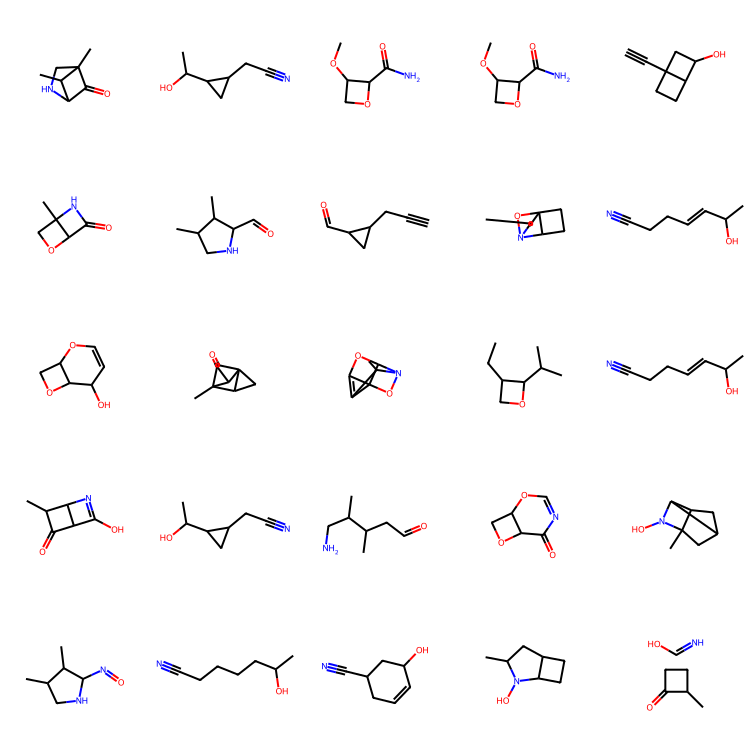

In [27]:
# Displaying the molecules as an image grid
MolsToGridImage(
    [m for m in molecules if m is not None][:25],
    molsPerRow=5,
    subImgSize=(150, 150)
)